In [1]:
import os
import time
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

PATH_TO_CFG = "Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config"
PATH_TO_CKPT = "Tensorflow/workspace/models/my_ssd_mobnet"

print('Loading model... ', end='')
start_time = time.time()

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATH_TO_CKPT, 'ckpt-6')).expect_partial()

@tf.function
def detect_fn(image):
    """Detect objects in image."""

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model... Done! Took 0.7175130844116211 seconds


In [2]:
PATH_TO_LABELS = 'Tensorflow/workspace/annotations/label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [3]:
IMAGE_PATHS = 'Tensorflow/workspace/images/test/images/zm3_9_img003.jpg'

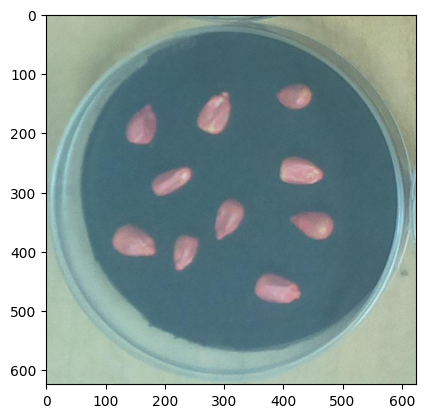

In [4]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

img = cv2.imread(IMAGE_PATHS)
image_np = np.array(img)

plt.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
plt.show()

Running inference for Tensorflow/workspace/images/test/images/zm3_9_img003.jpg... Done


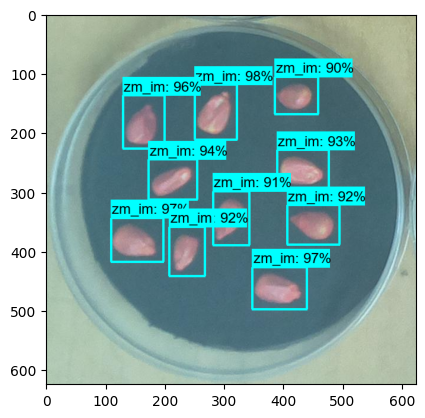

Number of bounding boxes with confidence over 70%: 10


In [5]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
from object_detection.utils import visualization_utils as viz_utils

warnings.filterwarnings('ignore')  # Suppress Matplotlib warnings

def load_image_into_numpy_array(path):

    return np.array(Image.open(path))

IMAGE_PATHS = IMAGE_PATHS  # Update with your image path

print('Running inference for {}... '.format(IMAGE_PATHS), end='')

image_np = load_image_into_numpy_array(IMAGE_PATHS)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

# Convert to numpy arrays and remove batch dimension
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

# Filter detections to keep only the class with ID 1
desired_class_id = 1
indices = np.where(detections['detection_classes'] == desired_class_id)[0]

filtered_boxes = detections['detection_boxes'][indices]
filtered_classes = detections['detection_classes'][indices]
filtered_scores = detections['detection_scores'][indices]

# Count the number of bounding boxes with confidence scores over 70%
confidence_threshold = 0.70
high_confidence_indices = np.where(filtered_scores > confidence_threshold)[0]
high_confidence_count = len(high_confidence_indices)

# Filter out detections below the confidence threshold
filtered_boxes = filtered_boxes[high_confidence_indices]
filtered_classes = filtered_classes[high_confidence_indices]
filtered_scores = filtered_scores[high_confidence_indices]

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections,
    filtered_boxes,
    filtered_classes + label_id_offset,
    filtered_scores,
    category_index,
    use_normalized_coordinates=True,
    max_boxes_to_draw=200,
    min_score_thresh=confidence_threshold,
    agnostic_mode=False
)

plt.figure()
plt.imshow(image_np_with_detections)
print('Done')
plt.show()

print(f'Number of bounding boxes with confidence over 70%: {high_confidence_count}')
